In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pmdarima as pm
from numpy.random import seed
from scipy import stats
import statsmodels.api as sm

In [2]:
# Spider-Man

In [3]:
Spide = pd.read_csv("Spider_Final.csv")
Spide = Spide[['Date', 'Units_Sold', 'Movie_Playing']]
Spide.head()

,Date,Units_Sold,Movie_Playing
0,1997-04,79143,0
1,1997-05,74425,0
2,1997-06,79804,0
3,1997-07,71808,0
4,1997-08,72365,0


In [4]:
Spide['Date'] = pd.to_datetime(Spide['Date'])

In [5]:
Spide.dtypes

Date             datetime64[ns]
Units_Sold                int64
Movie_Playing             int64
dtype: object

In [6]:
Spide.set_index('Date', inplace=True)
Spide.head()

,Units_Sold,Movie_Playing
Date,,
1997-04-01,79143,0
1997-05-01,74425,0
1997-06-01,79804,0
1997-07-01,71808,0
1997-08-01,72365,0


In [7]:
Spide.index

DatetimeIndex(['1997-04-01', '1997-05-01', '1997-06-01', '1997-07-01',
               '1997-08-01', '1997-09-01', '1997-10-01', '1997-11-01',
               '1997-12-01', '1998-01-01',
               ...
               '2019-08-01', '2019-08-01', '2019-09-01', '2019-09-01',
               '2019-10-01', '2019-10-01', '2019-11-01', '2019-11-01',
               '2019-12-01', '2019-12-01'],
              dtype='datetime64[ns]', name='Date', length=410, freq=None)

In [8]:
Spider = Spide.resample('M').mean()
Spider.head()

,Units_Sold,Movie_Playing
Date,,
1997-04-30,79143.0,0.0
1997-05-31,74425.0,0.0
1997-06-30,79804.0,0.0
1997-07-31,71808.0,0.0
1997-08-31,72365.0,0.0


In [9]:
Spider.isnull().values.any()

True

In [10]:
Spider.isnull().sum().sum()

30

In [11]:
is_NaN = Spider.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = Spider[row_has_NaN]
print(rows_with_NaN)

            Units_Sold  Movie_Playing
Date                                 
1998-10-31         NaN            NaN
2000-11-30         NaN            NaN
2002-04-30         NaN            NaN
2002-05-31         NaN            NaN
2003-06-30         NaN            NaN
2006-08-31         NaN            NaN
2006-10-31         NaN            NaN
2006-12-31         NaN            NaN
2007-04-30         NaN            NaN
2007-10-31         NaN            NaN
2007-11-30         NaN            NaN
2015-06-30         NaN            NaN
2015-07-31         NaN            NaN
2015-08-31         NaN            NaN
2015-09-30         NaN            NaN


In [12]:
Spider = Spider.fillna(method='ffill')

In [13]:
Spider.isnull().values.any()

False

In [14]:
#Statistics

In [15]:
np.random.seed(47)
N_rep = 10000
#Create function to run bootstrap sampling from
def bootstrap(data, func, N_rep):
    #Create empty array 
    bootstrap_rep = np.empty(N_rep)
    #Run bootstrap replicates
    for i in range(N_rep):
        bootstrap_sample = np.random.choice(data, len(data))
        bootstrap_rep[i] = func(bootstrap_sample)
    return bootstrap_rep

In [16]:
#Assign movie and no-movie array
movie = np.array(Spider[Spider['Movie_Playing']==1].Units_Sold)
no_movie = np.array(Spider[Spider['Movie_Playing']==0].Units_Sold)
#Find difference in mean between them
difference_mean = np.mean(movie) - np.mean(no_movie)
difference_mean

1090.9787759455212

In [17]:
#Difference of 10000 replicates
bootstrap_mean = bootstrap(movie, np.mean, N_rep) - bootstrap(no_movie, np.mean, N_rep)
#95% confidence interval
conf_interval = np.percentile(bootstrap_mean,[2.5, 97.5])
conf_interval

array([-7293.61686808,  9305.80123041])

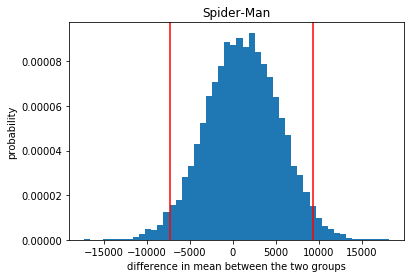

In [18]:
plt.hist(bootstrap_mean, bins=50, density=True)
plt.axvline(conf_interval[0], color='red')
plt.axvline(conf_interval[1], color='red')
plt.title("Spider-Man")
plt.xlabel('difference in mean between the two groups')
plt.ylabel('probability')
plt.savefig('Spider_Stat.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# P-Value

In [20]:
stats.ttest_ind(movie, no_movie, equal_var = False)

Ttest_indResult(statistic=0.2555524637840688, pvalue=0.7990490631463466)

In [21]:
# Linear Regression

In [22]:
#Without Movie_Playing External Predictor

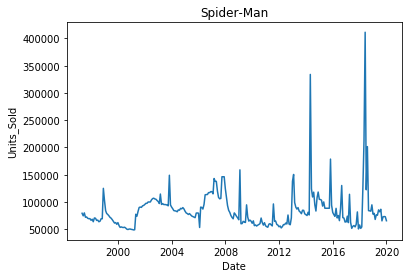

In [23]:
plt.title("Spider-Man")
sns.lineplot(x=Spider.index, y=Spider.Units_Sold, data=Spider)
plt.savefig('Spider_Line.png', dpi=300, bbox_inches='tight')

In [24]:
train = Spider.loc['1997-04-30':'2015-01-31']
test= Spider.loc['2015-02-28':]

In [25]:
train.head()

,Units_Sold,Movie_Playing
Date,,
1997-04-30,79143.0,0.0
1997-05-31,74425.0,0.0
1997-06-30,79804.0,0.0
1997-07-31,71808.0,0.0
1997-08-31,72365.0,0.0


In [26]:
test.head()

,Units_Sold,Movie_Playing
Date,,
2015-02-28,103219.0,0.0
2015-03-31,92289.0,0.0
2015-04-30,99964.0,0.0
2015-05-31,88338.0,0.0
2015-06-30,88338.0,0.0


In [27]:
test_no_movie = Spider[['Units_Sold']]
test_no_movie = test_no_movie.loc['2015-02-28':]
train_no_movie = Spider[['Units_Sold']]
train_no_movie = train_no_movie.loc['1997-04-30':'2015-01-31']

In [28]:
train.shape

(214, 2)

In [29]:
test.shape

(59, 2)

In [30]:
#Find p, d, and q values to build ARIMA model
#P is the order of the Auto Regressive (AR) term or the number of lags of Y to be used as predictors
#D is the number of differencing required to make the time series stationary
#Q is the order of the Moving Average (MA) term or the number of lagged forecast errors that should go into the ARIMA model

In [31]:
#ARIMA

In [32]:
#Auto ARIMA Forecast to choose best p,d,q
model_train_arima = pm.auto_arima(train[['Units_Sold']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True)

print(model_train_arima.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=4901.159, BIC=4914.604, Time=0.061 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=4965.373, BIC=4972.095, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=4928.783, BIC=4938.866, Time=0.032 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=4901.949, BIC=4912.033, Time=0.033 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=4963.379, BIC=4966.740, Time=0.009 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=4902.994, BIC=4919.801, Time=0.090 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=4903.212, BIC=4920.018, Time=0.139 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=4901.313, BIC=4914.758, Time=0.052 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=4916.671, BIC=4930.116, Time=0.049 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=4904.578, BIC=4924.746, Time=0.315 seconds
Near non-invertible roots for order 

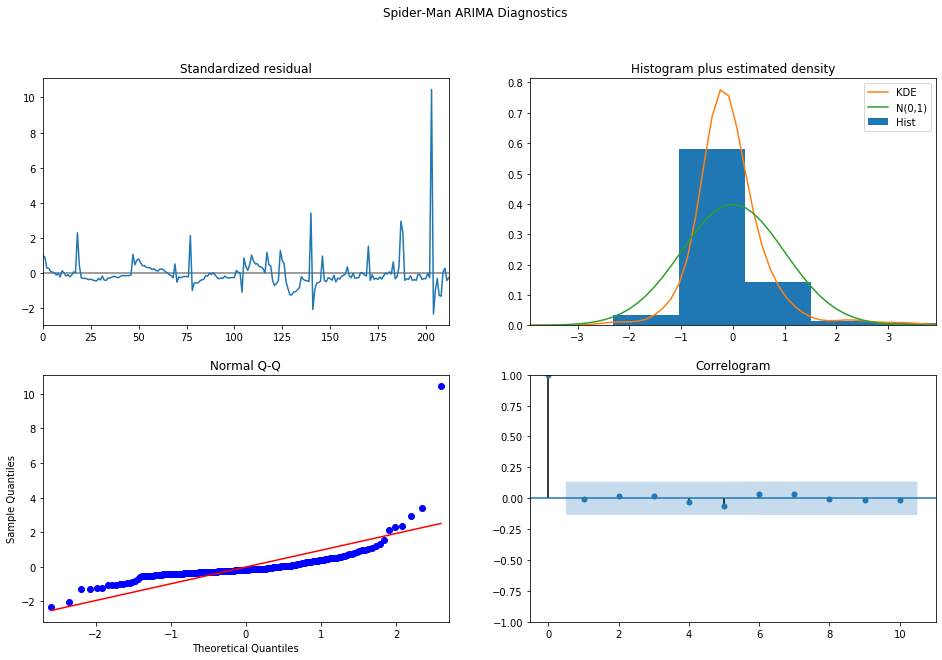

In [33]:
model_train_arima.plot_diagnostics(figsize=(16,10))
plt.suptitle("Spider-Man ARIMA Diagnostics")
plt.savefig('Spider_Diag_ARIMA.png', dpi=300, bbox_inches='tight')
plt.show()

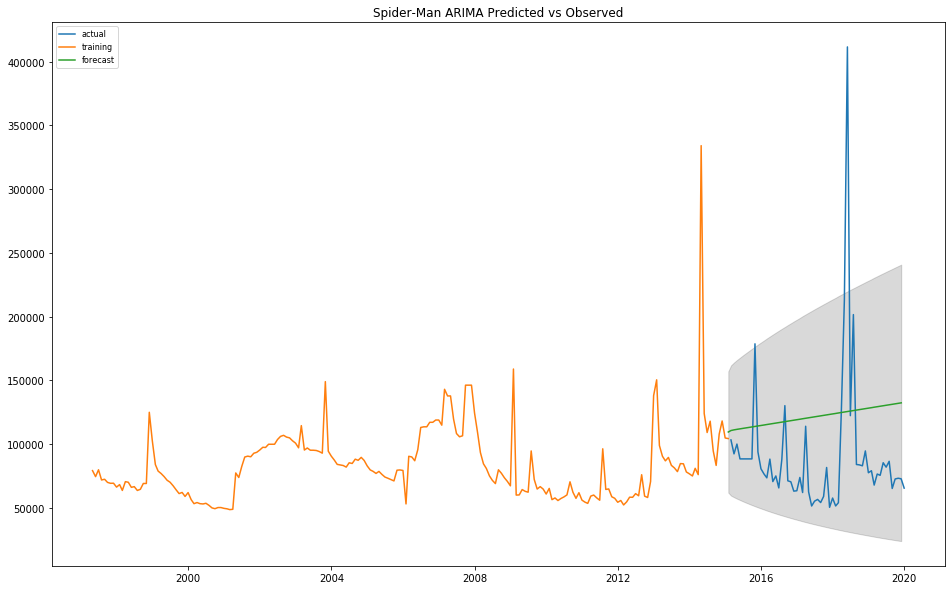

In [34]:
# Forecast
n_periods_arima = 59
fc_arima, confint_arima = model_train_arima.predict(n_periods=n_periods_arima, return_conf_int=True)
index_of_fc_arima = pd.date_range(train.index[-1], periods = n_periods_arima, freq='MS')

# make series for plotting purpose
fc_series_arima = pd.Series(fc_arima, index=index_of_fc_arima)
lower_series_arima = pd.Series(confint_arima[:, 0], index=index_of_fc_arima)
upper_series_arima = pd.Series(confint_arima[:, 1], index=index_of_fc_arima)

# Plot
plt.figure(figsize=(16,10))
plt.plot(test_no_movie, label='actual')
plt.plot(train_no_movie, label='training')
plt.plot(fc_series_arima, label='forecast')
plt.fill_between(lower_series_arima.index, lower_series_arima, upper_series_arima, color='k', alpha=.15)
plt.title("Spider-Man ARIMA Predicted vs Observed")
plt.legend(loc='upper left', fontsize=8)
plt.savefig('Spider_Predict_ARIMA.png', dpi=300, bbox_inches='tight')
plt.show()

In [35]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [36]:
mean_absolute_percentage_error(test_no_movie, fc_series_arima)

62.41582923251529

In [37]:
#SARIMA

In [38]:
#Auto SARIMA Forecast to choose best p,d,q
model_train_sarima = pm.auto_arima(train[['Units_Sold']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True)

print(model_train_sarima.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=4671.227, BIC=4687.744, Time=1.960 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=4753.180, BIC=4759.787, Time=0.040 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=4704.087, BIC=4717.300, Time=0.474 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=4674.755, BIC=4687.968, Time=0.580 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=4751.590, BIC=4754.893, Time=0.046 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=4709.080, BIC=4722.293, Time=0.347 seconds
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=4673.145, BIC=4692.965, Time=2.809 seconds
Fit ARIMA(1,1,1)x(0,1,2,12) [intercept=True]; AIC=4678.096, BIC=4697.916, Time=3.401 seconds
Fit ARIMA(1,1,1)x(1,1,0,12) [intercept=True]; AIC=4691.165, BIC=4707.682, Time=0.717 seconds
Fit ARIMA(1,1,1)x(1,1,2,12) [intercept=True]; AIC=4675.128, BIC=4698.252, Time=22.063 seconds
Near non-invertible roots

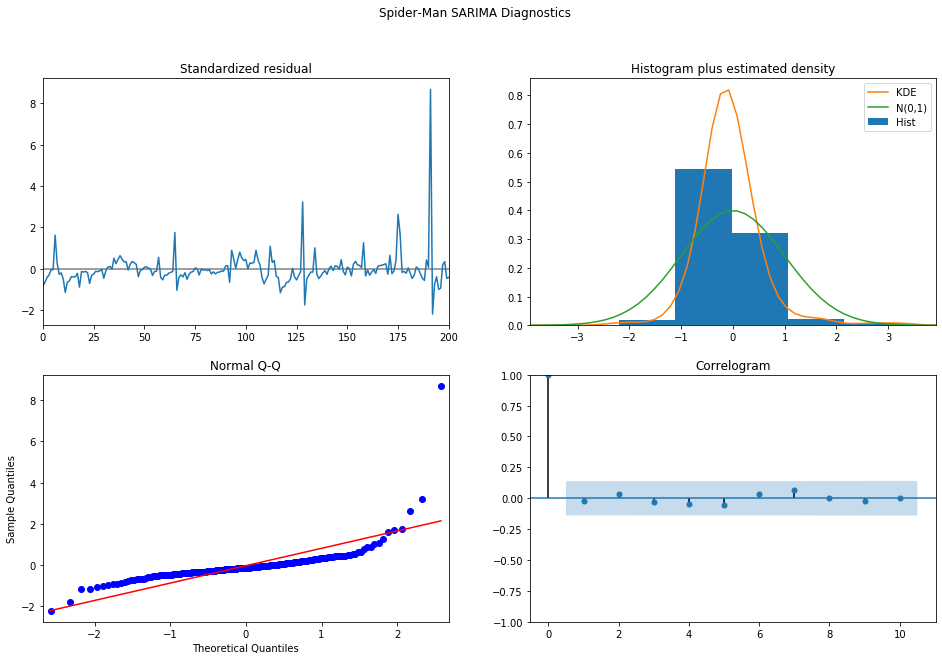

In [39]:
model_train_sarima.plot_diagnostics(figsize=(16,10))
plt.suptitle("Spider-Man SARIMA Diagnostics")
plt.savefig('Spider_Diag_SARIMA.png', dpi=300, bbox_inches='tight')
plt.show()

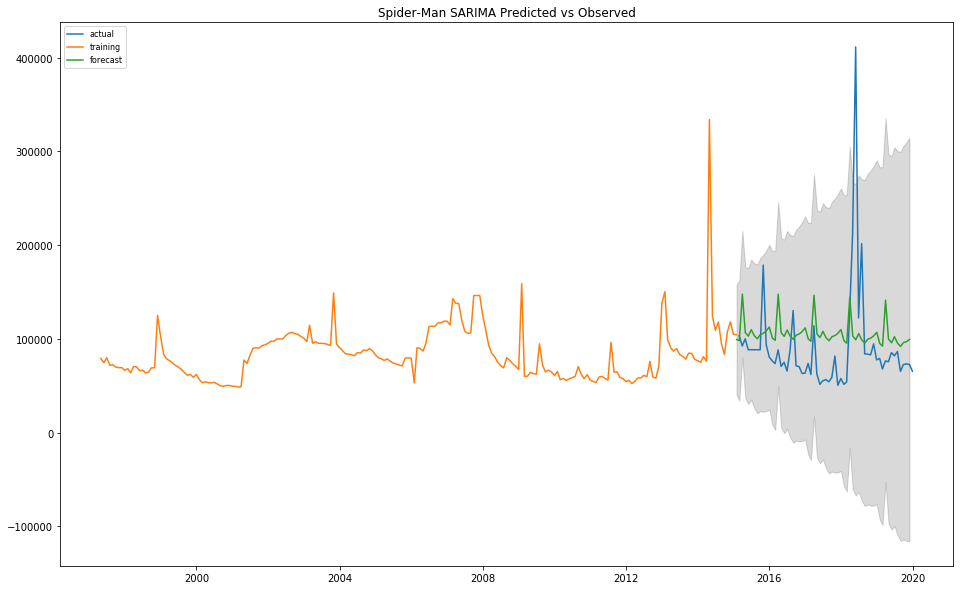

In [40]:
# Forecast
n_periods_sarima = 59
fc_sarima, confint_sarima = model_train_sarima.predict(n_periods=n_periods_sarima, return_conf_int=True)
index_of_fc_sarima = pd.date_range(train.index[-1], periods = n_periods_sarima, freq='MS')

# make series for plotting purpose
fc_series_sarima = pd.Series(fc_sarima, index=index_of_fc_sarima)
lower_series_sarima = pd.Series(confint_sarima[:, 0], index=index_of_fc_sarima)
upper_series_sarima = pd.Series(confint_sarima[:, 1], index=index_of_fc_sarima)

# Plot
plt.figure(figsize=(16,10))
plt.plot(test_no_movie, label='actual')
plt.plot(train_no_movie, label='training')
plt.plot(fc_series_sarima, label='forecast')
plt.fill_between(lower_series_sarima.index, lower_series_sarima, upper_series_sarima, color='k', alpha=.15)
plt.title("Spider-Man SARIMA Predicted vs Observed")
plt.legend(loc='upper left', fontsize=8)
plt.savefig('Spider_Predict_SARIMA.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
mean_absolute_percentage_error(test_no_movie, fc_series_sarima)

44.9177114823564

In [42]:
# With Movie_Playing External Predictor

In [43]:
#SARIMAX

In [44]:
#Auto SARIMAX Forecast to choose best p,d,q
model_train_sarimax = pm.auto_arima(train[['Units_Sold']], exogenous=train[['Movie_Playing']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True)

print(model_train_sarimax.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=4674.227, BIC=4694.047, Time=0.997 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=4747.766, BIC=4757.676, Time=0.071 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=4698.344, BIC=4714.860, Time=0.657 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=4672.367, BIC=4688.883, Time=0.720 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=5611.737, BIC=5618.344, Time=0.060 seconds
Fit ARIMA(0,1,1)x(0,1,0,12) [intercept=True]; AIC=4710.939, BIC=4724.152, Time=0.172 seconds
Fit ARIMA(0,1,1)x(1,1,1,12) [intercept=True]; AIC=4673.916, BIC=4693.736, Time=0.981 seconds
Fit ARIMA(0,1,1)x(0,1,2,12) [intercept=True]; AIC=4674.100, BIC=4693.919, Time=3.256 seconds
Fit ARIMA(0,1,1)x(1,1,0,12) [intercept=True]; AIC=4689.028, BIC=4705.544, Time=0.554 seconds
Fit ARIMA(0,1,1)x(1,1,2,12) [intercept=True]; AIC=4674.890, BIC=4698.014, Time=5.683 seconds
Fit ARIMA(0,1,0)x(0,1,1,12

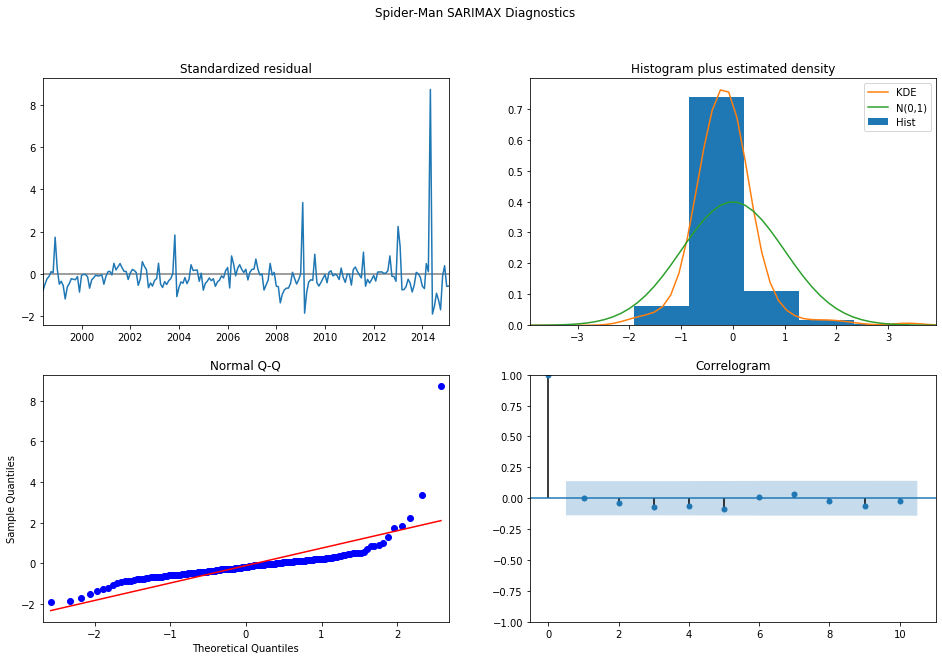

In [45]:
model_train_sarimax.plot_diagnostics(figsize=(16,10))
plt.suptitle("Spider-Man SARIMAX Diagnostics")
plt.savefig('Spider_Diag_SARIMAX.png', dpi=300, bbox_inches='tight')
plt.show()

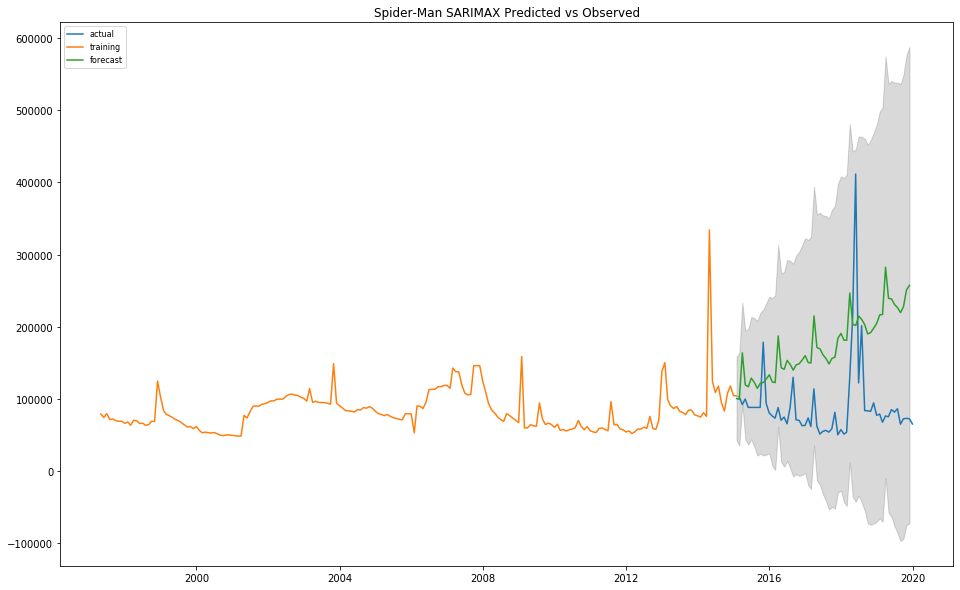

In [46]:
# Forecast
n_periods_sarimax = 59
fc_sarimax, confint_sarimax = model_train_sarimax.predict(n_periods=n_periods_sarimax, exogenous=test[['Movie_Playing']], 
                                                          return_conf_int=True)
index_of_fc_sarimax = pd.date_range(train.index[-1], periods = n_periods_sarimax, freq='MS')

# make series for plotting purpose
fc_series_sarimax = pd.Series(fc_sarimax, index=index_of_fc_sarimax)
lower_series_sarimax = pd.Series(confint_sarimax[:, 0], index=index_of_fc_sarimax)
upper_series_sarimax = pd.Series(confint_sarimax[:, 1], index=index_of_fc_sarimax)

# Plot
plt.figure(figsize=(16,10))
plt.plot(test[['Units_Sold']], label='actual')
plt.plot(train[['Units_Sold']], label='training')
plt.plot(fc_series_sarimax, label='forecast')
plt.fill_between(lower_series_sarimax.index, lower_series_sarimax, upper_series_sarimax, color='k', alpha=.15)
plt.title("Spider-Man SARIMAX Predicted vs Observed")
plt.legend(loc='upper left', fontsize=8)
plt.savefig('Spider_Predict_SARIMAX.png', dpi=300, bbox_inches='tight')
plt.show()

In [47]:
mean_absolute_percentage_error(test_no_movie, fc_series_sarimax)

127.44833322907412